In [87]:
pip install huggingface_hub[hf_xet]

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\4DS7\deepl\SpeechEmotionRecognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# Imports:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModel


d:\4DS7\deepl\SpeechEmotionRecognition\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data acquisition and understanding:

### Loading and decoding the data:

In [ ]:
def load_data(dataset):
    """
        Loads the paths of the sounds in the datasets
    """
    data = []
    directorypath = f"Data/{dataset}/"
    if dataset == "EmoDB":
        # Emotion code mapping
        emotion_map = {
            "W": "Anger",
            "L": "Boredom",
            "E": "Disgust",
            "A": "Fear",
            "F": "Happiness",
            "T": "Sadness",
            "N": "Neutral",
        }
        
        sentence_map_german = {
            "a01": "Der Lappen liegt auf dem Eisschrank.",
            "a02": "Das Messer ist in der Schublade.",
            "a04": "Heute abend könnte ich es ihm sagen.",
            "a05": "Das schwarze Stück Papier befindet sich da oben neben dem Holzstück.",
            "a07": "In sieben Stunden wird es soweit sein.",
            "b01": "Was sind denn das für Tüten, die da unter dem Tisch stehen?",
            "b02": "Sie haben es gerade hochgetragen und jetzt gehen sie wieder runter.",
            "b03": "An den Wochenenden bin ich jetzt immer nach Hause gefahren und habe Agnes besucht.",
            "b09": "Ich will das eben wegbringen und dann mit Karl was trinken gehen.",
            "b10": "Die wird auf dem Platz sein, wo wir sie immer hinlegen."
        }
        
        sentence_map_english = {
            "a01": "The cloth is lying on the icebox.",
            "a02": "The knife is in the drawer.",
            "a04": "I might tell him tonight.",
            "a05": "The black piece of paper is up there next to the piece of wood.",
            "a07": "In seven hours, it will be time.",
            "b01": "What kind of bags are those standing under the table?",
            "b02": "They just carried it up and now they're going back down.",
            "b03": "On weekends, I always went home and visited Agnes.",
            "b09": "I just want to drop this off and then go have a drink with Karl.",
            "b10": "She'll be in the spot where we always put her."
        }
        
        print("Loading EmoDB dataset")
        directorypath += "wav/"
        filenames = os.listdir(directorypath)
        sounds = [f for f in filenames if os.path.isfile(os.path.join(directorypath, f))]
        print(len(sounds), "sounds found")
        for sound in sounds:
            path = os.path.join(directorypath, sound)
            data.append(
                        {
                            "file_name": sound,
                            "path": path,
                            "speaker": sound[:2],
                            "sentence code": sound[2:5],
                            "sentence german": sentence_map_german[sound[2:5]],
                            "sentence": sentence_map_english[sound[2:5]],
                            "emotion code": sound[5],
                            "emotion": emotion_map[sound[5]],
                            "recording version": sound[6]
                        }
                        )
            
        df_emodb = pd.DataFrame(data)
    elif dataset == "RAVDESS":
        print("Loading RAVDESS dataset")
        actors = os.listdir(directorypath)
        
        modality_map = {
            "01": "full-AV,",
            "02": "video-only",
            "03": "audio-only"
        }
        
        vocal_channel_map = {
            "01": "speech",
            "02": "song"
        }
        
        emotion_map = {
            "01": "Neutral",
            "02": "Calm",
            "03": "Happiness",
            "04": "Sadness",
            "05": "Anger",
            "06": "Fear",
            "07": "Disgust",
            "08": "Surprised"
        }
        
        emotional_intensity_map = {
            "01": "normal",
            "02": "strong"
        }
        
        statement_map = {
            "01": "Kids are talking by the door.",
            "02": "Dogs are sitting by the door."
        }
        
        repetition_map = {
            "01": "1st repetition",
            "02": "2nd repetition"
        }
            
        for dir in actors:
            path = os.path.join(directorypath, dir)
            filenames = os.listdir(path)
            
            for sound in filenames:
                sound_path = os.path.join(path, sound)
                data.append(
                            {
                                "file_name": sound,
                                "speaker": dir,
                                "path": sound_path,
                                "modality_code": sound[:2],
                                "modality": modality_map[sound[:2]],
                                "vocal channel code": sound[3:5],
                                "vocal channel": vocal_channel_map[sound[3:5]],
                                "emotion_code": sound[6:8],
                                "emotion": emotion_map[sound[6:8]],
                                "emotion intensity code": sound[9:11],
                                "emotion intensity": emotional_intensity_map[sound[9:11]],
                                "sentence code": sound[12:14],
                                "sentence": statement_map[sound[12:14]],
                                "repetition code": sound[15:17],
                                "repetition": repetition_map[sound[15:17]],
                            }
                            )
        df_ravdess = pd.DataFrame(data)
        
    return df_emodb if dataset == "EmoDB" else df_ravdess

In [14]:
emodb = load_data("EmoDB")
ravdess = load_data("RAVDESS")

Loading EmoDB dataset
535 sounds found
Loading RAVDESS dataset


In [15]:
emodb.to_csv("Data/EmoDB.csv", index=False)
ravdess.to_csv("Data/RAVDESS.csv", index=False)

In [16]:
emodb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535 entries, 0 to 534
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          535 non-null    object
 1   path               535 non-null    object
 2   speaker            535 non-null    object
 3   sentence code      535 non-null    object
 4   sentence german    535 non-null    object
 5   sentence           535 non-null    object
 6   emotion code       535 non-null    object
 7   emotion            535 non-null    object
 8   recording version  535 non-null    object
dtypes: object(9)
memory usage: 37.7+ KB


In [17]:
ravdess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   file_name               1440 non-null   object
 1   speaker                 1440 non-null   object
 2   path                    1440 non-null   object
 3   modality_code           1440 non-null   object
 4   modality                1440 non-null   object
 5   vocal channel code      1440 non-null   object
 6   vocal channel           1440 non-null   object
 7   emotion_code            1440 non-null   object
 8   emotion                 1440 non-null   object
 9   emotion intensity code  1440 non-null   object
 10  emotion intensity       1440 non-null   object
 11  sentence code           1440 non-null   object
 12  sentence                1440 non-null   object
 13  repetition code         1440 non-null   object
 14  repetition              1440 non-null   object
dtypes: o

In [18]:
# Check for missing values
print(emodb.isnull().sum())
print(ravdess.isnull().sum())

file_name            0
path                 0
speaker              0
sentence code        0
sentence german      0
sentence             0
emotion code         0
emotion              0
recording version    0
dtype: int64
file_name                 0
speaker                   0
path                      0
modality_code             0
modality                  0
vocal channel code        0
vocal channel             0
emotion_code              0
emotion                   0
emotion intensity code    0
emotion intensity         0
sentence code             0
sentence                  0
repetition code           0
repetition                0
dtype: int64


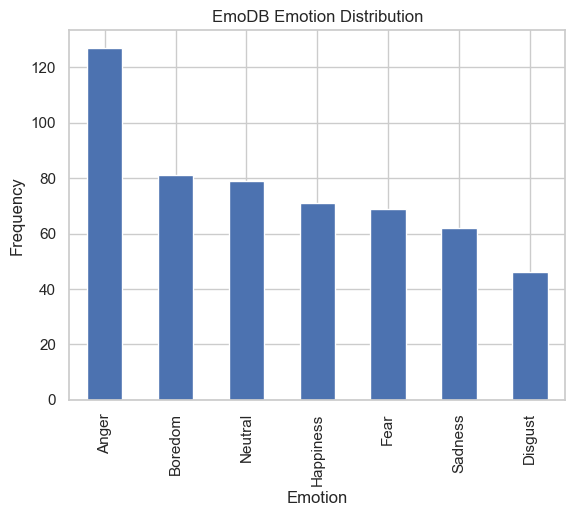

In [19]:
# EmoDB Emotion Distribution
emodb['emotion'].value_counts().plot(kind='bar', title='EmoDB Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
# plt.savefig("DataVis/EmoDB emotion distribution.png", format='png')
plt.show()



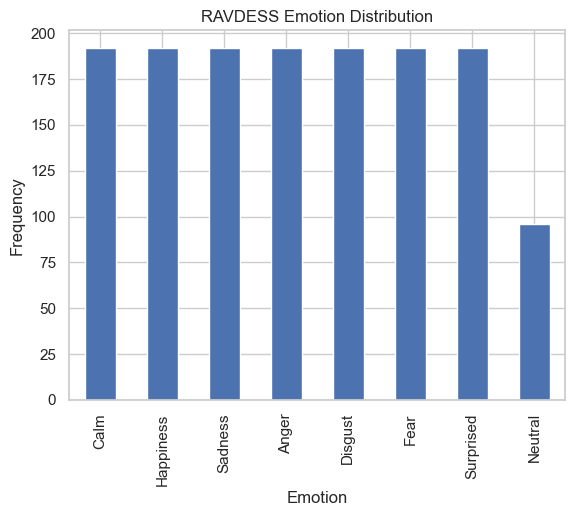

In [20]:
# RAVDESS Emotion Distribution
ravdess['emotion'].value_counts().plot(kind='bar', title='RAVDESS Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.savefig("DataVis/RAVDESS emotion distribution.png", format='png')
plt.show()

In [21]:
def extract_audio_features(file_path):
    # Load audio file using librosa
    y, sr = librosa.load(file_path, sr=None)  # sr=None to preserve the original sampling rate
    
    # Duration in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    
    # Perform Fourier Transform (FFT) to get frequencies
    D = librosa.stft(y)  # Short-Time Fourier Transform
    freqs = librosa.fft_frequencies(sr=sr)
    
    # Calculate average frequency
    avg_frequency = freqs.mean()
    
    return duration, avg_frequency

In [22]:
durations = []
frequencies = []

# Loop over each row in the dataset (EmoDB or RAVDESS)
for index, row in emodb.iterrows():  # Use ravdess_data for RAVDESS dataset
    file_path = row['path']  # Assuming the path column is named 'path'

    if file_path.endswith('.wav'):        
        # Extract audio features
        duration, avg_frequency = extract_audio_features(file_path)
        
        # Append to the lists
        durations.append(duration)
        frequencies.append(avg_frequency)

# Add the extracted features to the DataFrame
emodb['Duration (seconds)'] = durations  # Add Duration column
emodb['Average Frequency (Hz)'] = frequencies  # Add Frequency column


In [23]:
emodb

,file_name,path,speaker,sentence code,sentence german,sentence,emotion code,emotion,recording version,Duration (seconds),Average Frequency (Hz)
0,03a01Fa.wav,Data/EmoDB/wav/03a01Fa.wav,03,a01,Der Lappen liegt auf dem Eisschrank.,The cloth is lying on the icebox.,F,Happiness,a,1.898250,4000.0
1,03a01Nc.wav,Data/EmoDB/wav/03a01Nc.wav,03,a01,Der Lappen liegt auf dem Eisschrank.,The cloth is lying on the icebox.,N,Neutral,c,1.611250,4000.0
2,03a01Wa.wav,Data/EmoDB/wav/03a01Wa.wav,03,a01,Der Lappen liegt auf dem Eisschrank.,The cloth is lying on the icebox.,W,Anger,a,1.877813,4000.0
3,03a02Fc.wav,Data/EmoDB/wav/03a02Fc.wav,03,a02,Das Messer ist in der Schublade.,The knife is in the drawer.,F,Happiness,c,2.006250,4000.0
4,03a02Nc.wav,Data/EmoDB/wav/03a02Nc.wav,03,a02,Das Messer ist in der Schublade.,The knife is in the drawer.,N,Neutral,c,1.439812,4000.0
...,...,...,...,...,...,...,...,...,...,...,...
530,16b10Lb.wav,Data/EmoDB/wav/16b10Lb.wav,16,b10,"Die wird auf dem Platz sein, wo wir sie immer ...",She'll be in the spot where we always put her.,L,Boredom,b,3.442687,4000.0
531,16b10Tb.wav,Data/EmoDB/wav/16b10Tb.wav,16,b10,"Die wird auf dem Platz sein, wo wir sie immer ...",She'll be in the spot where we always put her.,T,Sadness,b,3.500625,4000.0
532,16b10Td.wav,Data/EmoDB/wav/16b10Td.wav,16,b10,"Die wird auf dem Platz sein, wo wir sie immer ...",She'll be in the spot where we always put her.,T,Sadness,d,3.934188,4000.0
533,16b10Wa.wav,Data/EmoDB/wav/16b10Wa.wav,16,b10,"Die wird auf dem Platz sein, wo wir sie immer ...",She'll be in the spot where we always put her.,W,Anger,a,2.414125,4000.0


In [24]:
durations = []
frequencies = []

# Loop over each row in the dataset (EmoDB or RAVDESS)
for index, row in ravdess.iterrows():  # Use ravdess_data for RAVDESS dataset
    file_path = row['path']  # Assuming the path column is named 'path'

    if file_path.endswith('.wav'):        
        # Extract audio features
        duration, avg_frequency = extract_audio_features(file_path)
        
        # Append to the lists
        durations.append(duration)
        frequencies.append(avg_frequency)

# Add the extracted features to the DataFrame
ravdess['Duration (seconds)'] = durations  # Add Duration column
ravdess['Average Frequency (Hz)'] = frequencies  # Add Frequency column

In [25]:
ravdess

,file_name,speaker,path,modality_code,modality,vocal channel code,vocal channel,emotion_code,emotion,emotion intensity code,emotion intensity,sentence code,sentence,repetition code,repetition,Duration (seconds),Average Frequency (Hz)
0,03-01-01-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,01,1st repetition,3.303292,12000.0
1,03-01-01-01-01-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,02,2nd repetition,3.336667,12000.0
2,03-01-01-01-02-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,01,1st repetition,3.269917,12000.0
3,03-01-01-01-02-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,3.169833,12000.0
4,03-01-02-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-02-01-01-01-01.wav,03,audio-only,01,speech,02,Calm,01,normal,01,Kids are talking by the door.,01,1st repetition,3.536854,12000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,03-01-08-01-02-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-01-02-02-24.wav,03,audio-only,01,speech,08,Surprised,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,3.403396,12000.0
1436,03-01-08-02-01-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-01-01-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,01,Kids are talking by the door.,01,1st repetition,3.937271,12000.0
1437,03-01-08-02-01-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-01-02-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,01,Kids are talking by the door.,02,2nd repetition,3.970625,12000.0
1438,03-01-08-02-02-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-02-01-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,02,Dogs are sitting by the door.,01,1st repetition,3.670333,12000.0


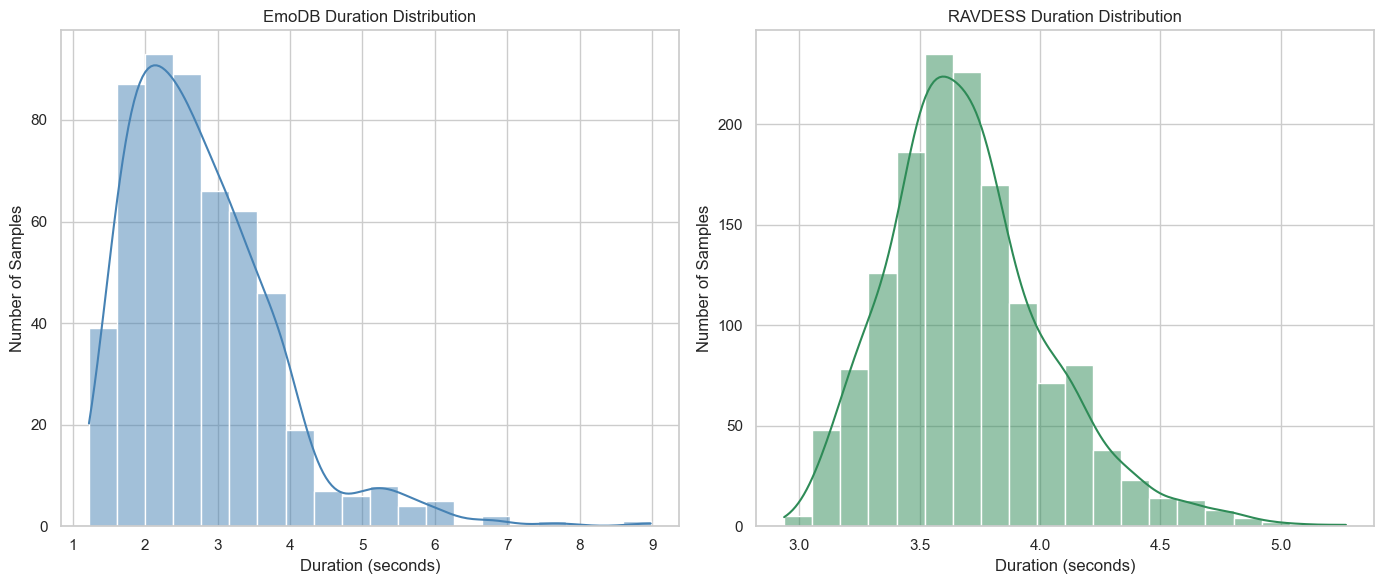

In [26]:
# Set a Seaborn style
sns.set(style="whitegrid")

# Create plots
plt.figure(figsize=(14, 6))

# EmoDB Duration Distribution
plt.subplot(1, 2, 1)
sns.histplot(emodb['Duration (seconds)'], bins=20, kde=True, color='steelblue')
plt.title('EmoDB Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Samples')

# RAVDESS Duration Distribution
plt.subplot(1, 2, 2)
sns.histplot(ravdess['Duration (seconds)'], bins=20, kde=True, color='seagreen')
plt.title('RAVDESS Duration Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.savefig("DataVis/Duration distribution.png", format='png')

plt.show()



C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14120\2975730754.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Dataset')


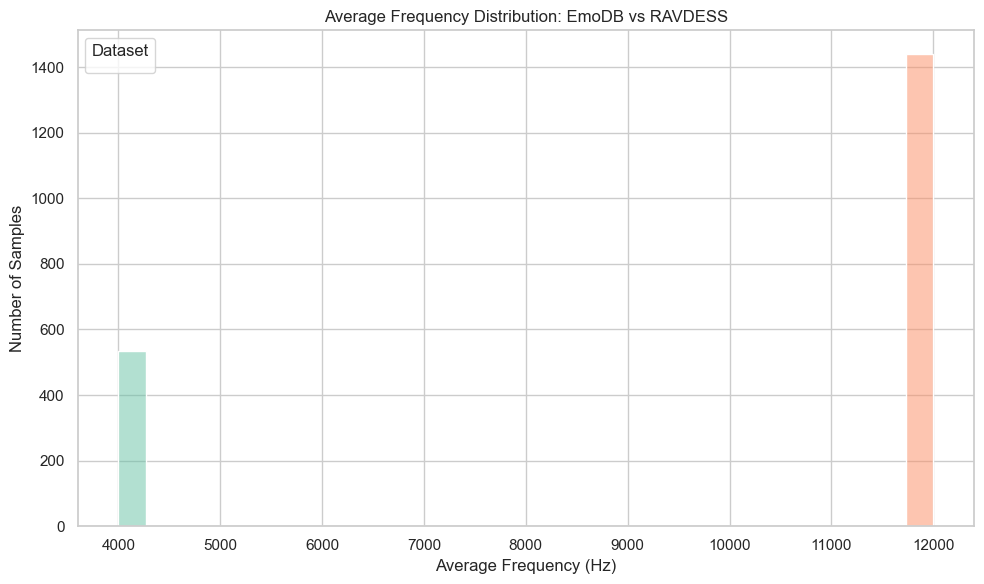

In [42]:
# Combine frequency data from both datasets
emodb_freq = pd.DataFrame({
    'Average Frequency (Hz)': emodb['Average Frequency (Hz)'],
    'Dataset': 'EmoDB'
})

ravdess_freq = pd.DataFrame({
    'Average Frequency (Hz)': ravdess['Average Frequency (Hz)'],
    'Dataset': 'RAVDESS'
})

# Concatenate into one DataFrame
combined_freq = pd.concat([emodb_freq, ravdess_freq], ignore_index=True)

# Plot: Histogram with KDE to compare frequency distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_freq, x='Average Frequency (Hz)', hue='Dataset', bins=30, kde=True, palette='Set2')
plt.title('Average Frequency Distribution: EmoDB vs RAVDESS')
plt.xlabel('Average Frequency (Hz)')
plt.ylabel('Number of Samples')
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig("DataVis/Average Frequency Distribution: EmoDB vs RAVDESS.png", format='png')

plt.show()

### Getting the sampling rate:

In [28]:
# Function to get native sampling rate of an audio file
def get_sampling_rate(file_path):
    try:
        _, sr = librosa.load(file_path, sr=None)  # sr=None preserves the original sampling rate
        return sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

In [29]:
emodb_sampling_rates = []

for _, row in emodb.iterrows():
    file_path = row['path']
    if file_path.endswith('.wav'):
        sr = get_sampling_rate(file_path)
        emodb_sampling_rates.append(sr)


emodb['Sampling Rate (Hz)'] = emodb_sampling_rates

In [30]:
emodb.to_csv("Data/EmoDB.csv", index=False)

In [31]:
ravdess_sampling_rates = []

for _, row in ravdess.iterrows():
    file_path = row['path']
    if file_path.endswith('.wav'):
        sr = get_sampling_rate(file_path)
        ravdess_sampling_rates.append(sr)


ravdess['Sampling Rate (Hz)'] = ravdess_sampling_rates

In [32]:
ravdess

,file_name,speaker,path,modality_code,modality,vocal channel code,vocal channel,emotion_code,emotion,emotion intensity code,emotion intensity,sentence code,sentence,repetition code,repetition,Duration (seconds),Average Frequency (Hz),Sampling Rate (Hz)
0,03-01-01-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,01,1st repetition,3.303292,12000.0,48000
1,03-01-01-01-01-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,02,2nd repetition,3.336667,12000.0,48000
2,03-01-01-01-02-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,01,1st repetition,3.269917,12000.0,48000
3,03-01-01-01-02-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,3.169833,12000.0,48000
4,03-01-02-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-02-01-01-01-01.wav,03,audio-only,01,speech,02,Calm,01,normal,01,Kids are talking by the door.,01,1st repetition,3.536854,12000.0,48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,03-01-08-01-02-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-01-02-02-24.wav,03,audio-only,01,speech,08,Surprised,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,3.403396,12000.0,48000
1436,03-01-08-02-01-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-01-01-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,01,Kids are talking by the door.,01,1st repetition,3.937271,12000.0,48000
1437,03-01-08-02-01-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-01-02-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,01,Kids are talking by the door.,02,2nd repetition,3.970625,12000.0,48000
1438,03-01-08-02-02-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-08-02-02-01-24.wav,03,audio-only,01,speech,08,Surprised,02,strong,02,Dogs are sitting by the door.,01,1st repetition,3.670333,12000.0,48000


In [33]:
# For EmoDB
selected_emodb = emodb[emodb['emotion'].isin(['Neutral', 'Anger', 'Happiness', 'Sadness', "Fear", 'Disgust'])]

# For RAVDESS
selected_ravdess = ravdess[ravdess['emotion'].isin(['Neutral', 'Anger', 'Happiness', 'Sadness', "Fear", 'Disgust'])]

In [34]:
selected_ravdess

,file_name,speaker,path,modality_code,modality,vocal channel code,vocal channel,emotion_code,emotion,emotion intensity code,emotion intensity,sentence code,sentence,repetition code,repetition,Duration (seconds),Average Frequency (Hz),Sampling Rate (Hz)
0,03-01-01-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,01,1st repetition,3.303292,12000.0,48000
1,03-01-01-01-01-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-01-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,01,Kids are talking by the door.,02,2nd repetition,3.336667,12000.0,48000
2,03-01-01-01-02-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-01-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,01,1st repetition,3.269917,12000.0,48000
3,03-01-01-01-02-02-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-01-01-02-02-01.wav,03,audio-only,01,speech,01,Neutral,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,3.169833,12000.0,48000
12,03-01-03-01-01-01-01.wav,Actor_01,Data/RAVDESS/Actor_01\03-01-03-01-01-01-01.wav,03,audio-only,01,speech,03,Happiness,01,normal,01,Kids are talking by the door.,01,1st repetition,3.470146,12000.0,48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,03-01-07-01-02-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-07-01-02-02-24.wav,03,audio-only,01,speech,07,Disgust,01,normal,02,Dogs are sitting by the door.,02,2nd repetition,4.070729,12000.0,48000
1428,03-01-07-02-01-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-07-02-01-01-24.wav,03,audio-only,01,speech,07,Disgust,02,strong,01,Kids are talking by the door.,01,1st repetition,4.337667,12000.0,48000
1429,03-01-07-02-01-02-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-07-02-01-02-24.wav,03,audio-only,01,speech,07,Disgust,02,strong,01,Kids are talking by the door.,02,2nd repetition,4.637958,12000.0,48000
1430,03-01-07-02-02-01-24.wav,Actor_24,Data/RAVDESS/Actor_24\03-01-07-02-02-01-24.wav,03,audio-only,01,speech,07,Disgust,02,strong,02,Dogs are sitting by the door.,01,1st repetition,4.237563,12000.0,48000


In [35]:
print(selected_emodb.columns)
print(selected_ravdess.columns)

Index(['file_name', 'path', 'speaker', 'sentence code', 'sentence german',
       'sentence', 'emotion code', 'emotion', 'recording version',
       'Duration (seconds)', 'Average Frequency (Hz)', 'Sampling Rate (Hz)'],
      dtype='object')
Index(['file_name', 'speaker', 'path', 'modality_code', 'modality',
       'vocal channel code', 'vocal channel', 'emotion_code', 'emotion',
       'emotion intensity code', 'emotion intensity', 'sentence code',
       'sentence', 'repetition code', 'repetition', 'Duration (seconds)',
       'Average Frequency (Hz)', 'Sampling Rate (Hz)'],
      dtype='object')


In [36]:
selected_emodb = selected_emodb[["file_name", "speaker", "path", "emotion", "sentence", "Duration (seconds)", "Sampling Rate (Hz)"]]
selected_ravdess = selected_ravdess[["file_name", "speaker", "path", "emotion", "sentence", "Duration (seconds)", "Sampling Rate (Hz)"]]

In [37]:
selected_emodb["dataset"] = "EmoDB"
selected_ravdess["dataset"] = "RAVDESS"

combined_df = pd.concat([selected_emodb, selected_ravdess], ignore_index=True)

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14120\2403109109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_ravdess["dataset"] = "RAVDESS"


In [38]:
combined_df.to_csv("Data/combined_dataset.csv", index=False)

# Data Preprocessing:

In [3]:
Data = pd.read_csv("Data/combined_dataset.csv")

In [39]:
Data.head()

,file_name,speaker,path,emotion,sentence,Duration (seconds),Sampling Rate (Hz),dataset
0,03a01Fa.wav,03,resampled_audio/Data/EmoDB/wav/03a01Fa.wav,Happiness,The cloth is lying on the icebox.,1.898250,16000,EmoDB
1,03a01Nc.wav,03,resampled_audio/Data/EmoDB/wav/03a01Nc.wav,Neutral,The cloth is lying on the icebox.,1.611250,16000,EmoDB
2,03a01Wa.wav,03,resampled_audio/Data/EmoDB/wav/03a01Wa.wav,Anger,The cloth is lying on the icebox.,1.877813,16000,EmoDB
3,03a02Fc.wav,03,resampled_audio/Data/EmoDB/wav/03a02Fc.wav,Happiness,The knife is in the drawer.,2.006250,16000,EmoDB
4,03a02Nc.wav,03,resampled_audio/Data/EmoDB/wav/03a02Nc.wav,Neutral,The knife is in the drawer.,1.439812,16000,EmoDB


## Resampling to 22025Hz:

In [5]:
def resample_audio(input_path, output_path, target_sr=22025):
    try:
        audio, original_sr = librosa.load(input_path, sr=None)  # Keep original SR
        resampled_audio = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
        sf.write(output_path, resampled_audio, target_sr)
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

In [6]:
# Resample
for i, row in Data.iterrows():
    input_path = row["path"]
    input_path = input_path[5:]  # Remove "Data/" prefix
    print(f"Processing {input_path}")
    input_path = "Data/" + input_path  # Add "Data/" prefix back for loading
    output_path = f"resampled_audio/{input_path}"  # This preserves subfolders

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    print(f"Creating directory: {output_dir}")
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Resampling {input_path} to {output_path}")

    # Resample and update path
    resample_audio(input_path, output_path)
    Data.at[i, "path"] = output_path  # Update path in the DataFrame

Processing EmoDB/wav/03a01Fa.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a01Fa.wav to resampled_audio/Data/EmoDB/wav/03a01Fa.wav
Processing EmoDB/wav/03a01Nc.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a01Nc.wav to resampled_audio/Data/EmoDB/wav/03a01Nc.wav
Processing EmoDB/wav/03a01Wa.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a01Wa.wav to resampled_audio/Data/EmoDB/wav/03a01Wa.wav
Processing EmoDB/wav/03a02Fc.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a02Fc.wav to resampled_audio/Data/EmoDB/wav/03a02Fc.wav
Processing EmoDB/wav/03a02Nc.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a02Nc.wav to resampled_audio/Data/EmoDB/wav/03a02Nc.wav
Processing EmoDB/wav/03a02Ta.wav
Creating directory: resampled_audio/Data/EmoDB/wav
Resampling Data/EmoDB/wav/03a02Ta.wav to resampled_audio/Data/EmoDB/wav/03a0

In [40]:
Data.to_csv("Data/after_resampling.csv", index=False)

C:\Users\Ibrahim\AppData\Local\Temp\ipykernel_14120\3597496937.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=labels, title="Dataset")


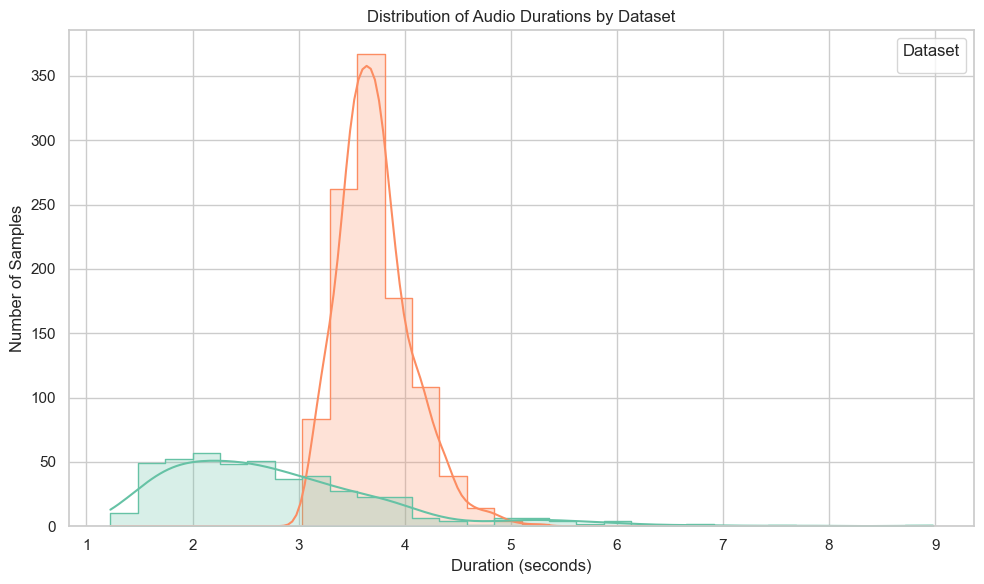

In [41]:
# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plot = sns.histplot(
    data=Data,
    x="Duration (seconds)",
    hue="dataset",
    bins=30,
    kde=True,
    palette="Set2",
    element="step",  # Optional: outlines instead of filled bars
)

# Customize the legend
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title="Dataset")

# Axis labels and title
plt.title("Distribution of Audio Durations by Dataset")
plt.xlabel("Duration (seconds)")
plt.ylabel("Number of Samples")

plt.tight_layout()
plt.savefig("DataVis/Distribution of Audio Durations by Dataset.png", format='png')
plt.show()

## Padding to the same duration 10s:

In [45]:
Data = pd.read_csv("Data/after_resampling.csv")

In [46]:
Data.head()

,file_name,speaker,path,emotion,sentence,Duration (seconds),Sampling Rate (Hz),dataset
0,03a01Fa.wav,03,resampled_audio/Data/EmoDB/wav/03a01Fa.wav,Happiness,The cloth is lying on the icebox.,1.898250,16000,EmoDB
1,03a01Nc.wav,03,resampled_audio/Data/EmoDB/wav/03a01Nc.wav,Neutral,The cloth is lying on the icebox.,1.611250,16000,EmoDB
2,03a01Wa.wav,03,resampled_audio/Data/EmoDB/wav/03a01Wa.wav,Anger,The cloth is lying on the icebox.,1.877813,16000,EmoDB
3,03a02Fc.wav,03,resampled_audio/Data/EmoDB/wav/03a02Fc.wav,Happiness,The knife is in the drawer.,2.006250,16000,EmoDB
4,03a02Nc.wav,03,resampled_audio/Data/EmoDB/wav/03a02Nc.wav,Neutral,The knife is in the drawer.,1.439812,16000,EmoDB


In [55]:
def pad_audio(input_path, output_path, target_duration=10, target_sr=22025):
    # Load the audio file
    audio, sr = librosa.load(input_path, sr=target_sr)  # Resample to target sampling rate if needed
    
    # Calculate the number of samples for the target duration
    target_samples = target_duration * target_sr
    
    # Pad the audio at the end if it's shorter than the target duration
    if len(audio) < target_samples:
        padding_length = target_samples - len(audio)
        audio = np.pad(audio, (0, padding_length), mode='constant')  # Pad at the end with zeros
    
    # Save the padded audio to the output path
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    sf.write(output_path, audio, target_sr)

    return output_path

In [56]:
# Loop through the DataFrame and pad each audio file
for i, row in Data.iterrows():
    input_path = row["path"]
    audio_processed = input_path[21:]  # Remove "resampled_audio/Data/" prefix
    print(f"Padding {audio_processed}")
    output_path = f"Data/padded_audio/{audio_processed}"  # Set the output path for padded audio
    print(f"Output path: {output_path}")
    
    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
        
    # Pad the audio to 10 seconds (adding silence at the end)
    padded_path = pad_audio(input_path, output_path, target_duration=10, target_sr=22025)
    
    # Update the DataFrame with the new path
    Data.at[i, "path"] = padded_path  # Update the path to the padded version

Padding EmoDB/wav/03a01Fa.wav
Output path: Data/padded_audio/EmoDB/wav/03a01Fa.wav
Padding EmoDB/wav/03a01Nc.wav
Output path: Data/padded_audio/EmoDB/wav/03a01Nc.wav
Padding EmoDB/wav/03a01Wa.wav
Output path: Data/padded_audio/EmoDB/wav/03a01Wa.wav
Padding EmoDB/wav/03a02Fc.wav
Output path: Data/padded_audio/EmoDB/wav/03a02Fc.wav
Padding EmoDB/wav/03a02Nc.wav
Output path: Data/padded_audio/EmoDB/wav/03a02Nc.wav
Padding EmoDB/wav/03a02Ta.wav
Output path: Data/padded_audio/EmoDB/wav/03a02Ta.wav
Padding EmoDB/wav/03a02Wb.wav
Output path: Data/padded_audio/EmoDB/wav/03a02Wb.wav
Padding EmoDB/wav/03a02Wc.wav
Output path: Data/padded_audio/EmoDB/wav/03a02Wc.wav
Padding EmoDB/wav/03a04Ad.wav
Output path: Data/padded_audio/EmoDB/wav/03a04Ad.wav
Padding EmoDB/wav/03a04Fd.wav
Output path: Data/padded_audio/EmoDB/wav/03a04Fd.wav
Padding EmoDB/wav/03a04Nc.wav
Output path: Data/padded_audio/EmoDB/wav/03a04Nc.wav
Padding EmoDB/wav/03a04Ta.wav
Output path: Data/padded_audio/EmoDB/wav/03a04Ta.wav
Padd

In [58]:
Data.to_csv("Data/after_padding.csv", index=False)

## Extracting Mel-spectrograms:

In [2]:
Data = pd.read_csv("Data/after_padding.csv")

In [3]:
Data.head()

,file_name,speaker,path,emotion,sentence,Duration (seconds),Sampling Rate (Hz),dataset
0,03a01Fa.wav,03,Data/padded_audio/EmoDB/wav/03a01Fa.wav,Happiness,The cloth is lying on the icebox.,1.898250,16000,EmoDB
1,03a01Nc.wav,03,Data/padded_audio/EmoDB/wav/03a01Nc.wav,Neutral,The cloth is lying on the icebox.,1.611250,16000,EmoDB
2,03a01Wa.wav,03,Data/padded_audio/EmoDB/wav/03a01Wa.wav,Anger,The cloth is lying on the icebox.,1.877813,16000,EmoDB
3,03a02Fc.wav,03,Data/padded_audio/EmoDB/wav/03a02Fc.wav,Happiness,The knife is in the drawer.,2.006250,16000,EmoDB
4,03a02Nc.wav,03,Data/padded_audio/EmoDB/wav/03a02Nc.wav,Neutral,The knife is in the drawer.,1.439812,16000,EmoDB


In [62]:
def extract_mel_spectrogram(file_path):
    N_FFT = 1024                # Window size for STFT
    HOP_LENGTH = 256            # Hop length between windows
    N_MELS = 128                # Number of mel bands
    
    audio, sr = librosa.load(file_path, sr=None)

    # Compute mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        power=2.0  # Power=2.0 gives power spectrogram (squared magnitude)
    )
    
    # Convert to decibels for better visualization
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Z-score normalization
    mean = mel_spec_db.mean()
    std = mel_spec_db.std()
    mel_spec_norm = (mel_spec_db - mean) / std
    
    return mel_spec_norm

In [63]:
mel_npy_paths = []
mel_png_paths = []

# Loop through the DataFrame
for i, row in Data.iterrows():
    input_path = row["path"]
    
    # Paths for .npy and .png
    mel_base_path = input_path.replace("padded_audio", "mel_spectrograms").replace(".wav", "")
    npy_path = mel_base_path + ".npy"
    png_path = mel_base_path + ".png"
    
    # Extract mel-spectrogram
    mel_spec = extract_mel_spectrogram(input_path)
    
    # Save .npy
    os.makedirs(os.path.dirname(npy_path), exist_ok=True)
    np.save(npy_path, mel_spec)
    
    # Save .png
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=22025, hop_length=256, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.savefig(png_path)
    plt.close()

    # Track paths
    mel_npy_paths.append(npy_path)
    mel_png_paths.append(png_path)

# Add columns to DataFrame
Data["mel_npy_path"] = mel_npy_paths
Data["mel_png_path"] = mel_png_paths


In [78]:
Data.to_csv("Data/after_preprocessing.csv", index=False)

In [238]:
mel = np.load("Data/mel_spectrograms/RAVDESS/Actor_01/03-01-01-01-01-01-01.npy")
print(mel.shape)

(128, 861)


In [153]:
print("min:", mel.min())
print("max:", mel.max())

min: -0.36402068
max: 6.0417414


## Encoding:

In [18]:
Data = pd.read_csv("Data/after_preprocessing.csv")

In [19]:
label_encoder = LabelEncoder()
Data['emotion_encoded'] = label_encoder.fit_transform(Data['emotion'])
OneHot = OneHotEncoder(sparse_output=False)
encoded_labels = OneHot.fit_transform(Data[['emotion_encoded']])
print(encoded_labels.shape)

# Convert to tensor
onehot_labels = torch.tensor(encoded_labels).float()

(1510, 6)


In [20]:
encoded_labels

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], shape=(1510, 6))

In [21]:
onehot_labels

tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])

In [22]:
emotion_classes = label_encoder.classes_
onehot_df = pd.DataFrame(encoded_labels, columns=[f"emotion_{cls}" for cls in emotion_classes])

In [23]:
Data = pd.concat([Data.reset_index(drop=True), onehot_df.reset_index(drop=True)], axis=1)

In [24]:
Data.to_csv("Data/encoding.csv", index=False)

# Modeling:

## SER-model:

In [2]:
class SERDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.ToTensor(),                           # Converts [H, W] → [1, H, W]
            transforms.Resize((224, 224)),                   # Resize to 224x224
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))   # [1, H, W] → [3, H, W]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        mel_path = row['mel_npy_path']
        label = int(row['emotion_encoded'])

        # Load Mel-spectrogram from .npy
        mel_spec = np.load(mel_path)  # shape: [H, W]

        # Convert to PIL image for compatibility with transforms
        mel_image = Image.fromarray(mel_spec.astype(np.float32), mode='F')  # 'F' = 32-bit float grayscale

        # Apply transform
        mel_tensor = self.transform(mel_image)  # shape: [3, 224, 224]

        return mel_tensor, label

In [3]:
train_df = pd.read_csv("Data/split_train_val/train_split.csv")
val_df = pd.read_csv("Data/split_train_val/val_split.csv")

In [4]:
train_dataset = SERDataset(csv_path="Data/split_train_val/train_split.csv")
val_dataset = SERDataset(csv_path="Data/split_train_val/val_split.csv")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [5]:
class EmotionResNet50(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.4):
        super(EmotionResNet50, self).__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Get input size of the original fully connected layer
        in_features = self.base_model.fc.in_features

        # Replace the final fc layer with Dropout + Linear
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)
    
    def get_embedding(self, x):
        # Forward until the layer before classification
        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.base_model.avgpool(x)
        x = torch.flatten(x, 1)
        return x  # This is your emotion embedding

In [6]:
def train_model(model, train_loader, val_loader, device, learning_rate=1e-4, epochs=800, checkpoint_dir='checkpoints/EmotionResNet50', weight_decay=1e-5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = CrossEntropyLoss()

    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Lists to store the history of the metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        # Calculate accuracy for the training set
        train_accuracy = correct / total
        train_losses.append(running_loss / len(train_loader))  # Add average loss for the epoch
        train_accuracies.append(train_accuracy)  # Add accuracy for the epoch

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():  # No need to compute gradients during validation
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets)

                val_running_loss += val_loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_targets).sum().item()
                val_total += val_targets.size(0)

                all_preds.extend(val_predicted.cpu().numpy())
                all_targets.extend(val_targets.cpu().numpy())

        # Calculate accuracy and F1 score for the validation set
        val_accuracy = val_correct / val_total
        val_f1 = f1_score(all_targets, all_preds, average='weighted')
        
        val_losses.append(val_running_loss / len(val_loader))  # Add average loss for the epoch
        val_accuracies.append(val_accuracy)  # Add accuracy for the epoch
        val_f1_scores.append(val_f1)  # Add F1 score for the epoch

        # Print statistics
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}")

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
                'val_f1': val_f1
            }, checkpoint_path)
            print(f"Checkpoint saved at epoch {epoch+1} to {checkpoint_path}")

    # Return the history of training and validation metrics
    history = {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'val_f1_scores': val_f1_scores
    }
    return history

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_pre = EmotionResNet50(num_classes=6).to(device)

In [28]:
history = train_model(model_pre, train_loader, val_loader, device, learning_rate=1e-4, epochs=800)

Epoch 1/800, Train Loss: 130.8429, Train Accuracy: 0.2724, Val Loss: 30.3591, Val Accuracy: 0.3278, Val F1 Score: 0.2303
Epoch 2/800, Train Loss: 100.6775, Train Accuracy: 0.5066, Val Loss: 23.8945, Val Accuracy: 0.5199, Val F1 Score: 0.5051
Epoch 3/800, Train Loss: 62.1326, Train Accuracy: 0.7326, Val Loss: 20.9686, Val Accuracy: 0.6225, Val F1 Score: 0.6135
Epoch 4/800, Train Loss: 31.8009, Train Accuracy: 0.8618, Val Loss: 19.3539, Val Accuracy: 0.6325, Val F1 Score: 0.6342
Epoch 5/800, Train Loss: 19.1490, Train Accuracy: 0.9263, Val Loss: 23.6257, Val Accuracy: 0.5960, Val F1 Score: 0.5927
Checkpoint saved at epoch 5 to checkpoints/EmotionResNet50\checkpoint_epoch_5.pth
Epoch 6/800, Train Loss: 17.6435, Train Accuracy: 0.9272, Val Loss: 21.1591, Val Accuracy: 0.6126, Val F1 Score: 0.6165
Epoch 7/800, Train Loss: 17.7303, Train Accuracy: 0.9263, Val Loss: 24.7380, Val Accuracy: 0.6093, Val F1 Score: 0.6029
Epoch 8/800, Train Loss: 13.7936, Train Accuracy: 0.9396, Val Loss: 24.7274,

KeyboardInterrupt: 

In [36]:
best_ser_model = EmotionResNet50(num_classes=6).to(device)

checkpoint_path = 'checkpoints/EmotionResNet50/checkpoint_epoch_200.pth'

checkpoint = torch.load(checkpoint_path, map_location=device)
best_ser_model.load_state_dict(checkpoint['model_state_dict'])

# Optional: load optimizer state too (if you plan to continue training)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"Model loaded from {checkpoint_path}, epoch {checkpoint['epoch']}")

Model loaded from checkpoints/EmotionResNet50/checkpoint_epoch_200.pth, epoch 200


In [37]:
# Initialize variables to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation during evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = best_ser_model(inputs)
        
        # Get predicted class indices
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy and F1 score
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')  # or 'macro', depending on your preference

print(f"Accuracy on validation set: {accuracy:.4f}")
print(f"F1 score on validation set: {f1:.4f}")

Accuracy on validation set: 0.7450
F1 score on validation set: 0.7428


In [37]:
def ser_confusion_matrix():
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_ser_model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Validation Confusion Matrix")
    plt.savefig("DataVis/SER_Confusion_Matrix.png", format='png')
    plt.show()

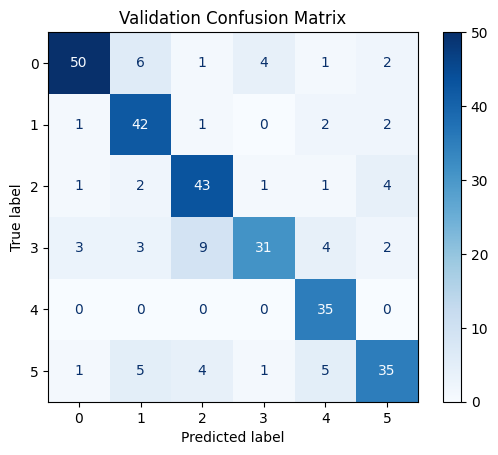

In [38]:
ser_confusion_matrix()

## Mel_style encoder:

In [7]:
class MelDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.mel_paths = self.df["mel_npy_path"].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.mel_paths)

    def __getitem__(self, idx):
        mel = np.load(self.mel_paths[idx])  # Shape: (n_mels, time)
        mel = (mel - mel.min()) / (mel.max() - mel.min()) # Normalize to [0, 1]
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, time)
        if self.transform:
            mel = self.transform(mel)
        return mel

In [8]:
class ResidualConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.activation = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.activation(x + self.block(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_residual=True):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.residual = ResidualConvBlock(out_channels) if use_residual else nn.Identity()

    def forward(self, x):
        x = self.initial(x)
        return self.residual(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    
    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.attn = SkipAttention(out_channels)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        skip = self.attn(skip)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class SkipAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, skip):
        return skip * self.attn(skip)



In [9]:
class MelEncoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.initial_conv = ConvBlock(1, 32)
        self.down1 = DownBlock(32, 64)       # H/2, W/2
        self.down2 = DownBlock(64, 128)      # H/4, W/4
        self.down3 = DownBlock(128, 256)      # H/8, W/8
        self.down4 = DownBlock(256, 512)      # H/16, W/16
        self.final_block = nn.Sequential(
            nn.MaxPool2d(2),                  # H/32, W/32
            ConvBlock(512, embedding_dim)
        )

    def forward(self, x):
        skips = []
        x = self.initial_conv(x)   # -> [B, 32, H, W]
        skips.append(x)

        x = self.down1(x)          # -> [B, 64, H/2, W/2]
        skips.append(x)

        x = self.down2(x)          # -> [B, 128, H/4, W/4]
        skips.append(x)

        x = self.down3(x)          # -> [B, 256, H/8, W/8]
        skips.append(x)

        x = self.down4(x)          # -> [B, 512, H/16, W/16]
        skips.append(x)

        x = self.final_block(x)    # -> [B, 1024, H/32, W/32]
        return x, skips

In [23]:
class MelDecoder(nn.Module):
    def __init__(self, embedding_dim=1024):
        super().__init__()
        self.up1 = UpBlock(embedding_dim, 512)       # H/16
        self.up2 = UpBlock(512, 256)                 # H/8
        self.up3 = UpBlock(256, 128)                 # H/4
        self.up4 = UpBlock(128, 64)                  # H/2
        self.up5 = UpBlock(64, 32)                   # H
        self.final_conv = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, z, skips):
        x = self.up1(z, skips[4])        # -> [B, 512, H/16, W/16]
        x = self.up2(x, skips[3])        # -> [B, 256, H/8, W/8]
        x = self.up3(x, skips[2])        # -> [B, 128, H/4, W/4]
        x = self.up4(x, skips[1])        # -> [B, 64, H/2, W/2]
        x = self.up5(x, skips[0])        # -> [B, 32, H, W]
        return self.final_conv(x)

In [24]:
class MelAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, embedding_dim=1024):
        super().__init__()
        self.encoder = MelEncoder(embedding_dim)
        self.decoder = MelDecoder(embedding_dim)

    def forward(self, x):
        z, skips = self.encoder(x)
        return self.decoder(z, skips)


In [25]:
def train_auto_encoder(model, train_loader, val_loader, epochs=200, checkpoint_dir='checkpoints/reference_encoder'):
    model.to(device)
    optimizer = optim.Adam(
        list(model.parameters()),
        lr=1e-3, weight_decay=1e-4  # L2 regularization term
    )

    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # ----- Training -----
        model.train()
        train_loss = 0
        for mel in train_loader:
            mel = mel.to(device)  # [B, 1, M, T]
            recon = model(mel)
            loss = F.l1_loss(recon, mel) + 0.1 * F.mse_loss(recon, mel)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # ----- Validation -----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mel in val_loader:
                mel = mel.to(device)
                recon = model(mel)
                loss = F.l1_loss(recon, mel)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # ----- Save checkpoint -----
        if epoch % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved to {checkpoint_path}")


In [26]:
train_df = pd.read_csv("Data/split_train_val/train_split.csv")
val_df = pd.read_csv("Data/split_train_val/val_split.csv")

train_df["mel_npy_path"] = train_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))
val_df["mel_npy_path"] = val_df["mel_npy_path"].apply(lambda x: x.replace("\\", "/"))

train_dataset = MelDataset(csv_path="Data/split_train_val/train_split.csv")
val_dataset = MelDataset(csv_path="Data/split_train_val/val_split.csv")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = MelEncoder(embedding_dim=1024).to(device)
decoder = MelDecoder(embedding_dim=1024).to(device)
autoencoder = MelAutoencoder(encoder=encoder, decoder=decoder).to(device)

# train_auto_encoder(autoencoder, train_loader, val_loader, epochs=200)

cuda


In [28]:
def visualize_first_5(autoencoder, encoder, decoder, dataloader, device, checkpoint_path = 'checkpoints/auto-encoder/checkpoint_epoch_20.pth'):
    mel_encoder = encoder(embedding_dim=1024).to(device)
    mel_decoder = decoder(embedding_dim=1024).to(device)
    me_autoencoder = autoencoder(encoder=mel_encoder, decoder=mel_decoder).to(device)
    
    me_autoencoder.load_state_dict(torch.load(checkpoint_path, map_location=device))
    me_autoencoder.eval()
    
    checkpoint_path = 'models/MelEncoder.pth'
    torch.save(mel_encoder.state_dict(), checkpoint_path)
    print(f"Encoder model saved to {checkpoint_path}")

    with torch.no_grad():
        for batch in dataloader:
            original = batch.to(device)
            reconstructed = me_autoencoder(original)
            break  # Only take the first batch

    original = original.cpu()
    reconstructed = reconstructed.cpu()

    # Plot the first 5 samples
    for i in range(5):
        plt.figure(figsize=(10, 3))

        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(original[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Original #{i+1}')
        plt.colorbar()

        # Reconstructed
        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed[i][0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f'Reconstructed #{i+1}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()


In [ ]:
visualize_first_5(MelAutoencoder, MelEncoder, MelDecoder, val_loader, device)

## Transformer encoder:

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, model_name="bert-base-multilingual-cased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)  # Mean pooling over tokens
        return pooled  # shape: [batch_size, hidden_dim]
    
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


## Diffusion model:

In [11]:
class DiffusionModelDataset(Dataset):
    def __init__(self, csv_path, ser_model, mel_encoder, text_model, tokenizer, max_text_len=200, transform=None):
        """
        Args:
            csv_path (str): Path to CSV containing paths and labels
            ser_model: Speech Emotion Recognition model class
            mel_encoder: MelEncoder model class
            text_model: SmallTextTransformer instance
            tokenizer: Text tokenizer (e.g., from transformers)
            max_text_len: Maximum text sequence length
            transform: Optional transforms for mel spectrograms
        """
        self.df = pd.read_csv(csv_path)
        self.mel_paths = self.df["mel_npy_path"].tolist()
        self.labels = self.df["emotion_encoded"].tolist()
        self.texts = self.df["sentence"].tolist()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = tokenizer
        self.max_text_len = max_text_len
        
        # Initialize models
        self.ser_model = ser_model(num_classes=6).to(self.device)
        self.mel_encoder = mel_encoder(embedding_dim=1024).to(self.device)
        self.text_model = text_model().to(self.device)
        
        # Load checkpoints
        ser_checkpoint = torch.load('models/SER.pth', map_location=self.device)
        self.ser_model.load_state_dict(ser_checkpoint['model_state_dict'])
        self.ser_model.eval()
        
        mel_checkpoint = torch.load('models/MelEncoder.pth', map_location=self.device)
        self.mel_encoder.load_state_dict(mel_checkpoint)
        self.mel_encoder.eval()
        
        self.transform = transform if transform else transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Lambda(lambda x: x.repeat(3, 1, 1))
        ])

    def __len__(self):
        return len(self.mel_paths)

    def __getitem__(self, idx):
        # Load and process Mel-spectrogram
        mel_spec = np.load(self.mel_paths[idx])
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
        mel_tensor = self.transform(
            Image.fromarray((mel_spec * 255).astype(np.uint8), mode='L')
        ).to(self.device)
        
        # Input for the MelEncoder
        mel = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).to(self.device)
        init_mel = mel.squeeze(0)
        
        # Process text
        text = self.texts[idx]
        inputs = self.tokenizer(
            text,
            max_length=self.max_text_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(self.device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        
        # Get embeddings
        with torch.no_grad():
            # Audio embeddings
            emotions_embedding = self.ser_model.get_embedding(mel_tensor.unsqueeze(0))
            emotions_embedding = emotions_embedding.view(-1)
            utterance_vector, _ = self.mel_encoder(mel.unsqueeze(0))
            utterance_vector = utterance_vector.squeeze(0)
            
            # Text embedding
            text_embedding = self.text_model(input_ids, attention_mask)
            text_embedding = text_embedding.squeeze(0)
        
        return {
            # 'audio_emotion': emotions_embedding.squeeze(0),
            # 'mel_embedding': utterance_vector.squeeze(0),
            # 'text_embedding': text_embedding.squeeze(0),
            # 'label': torch.tensor(self.labels[idx].to(self.device))
            'emotion_embedding': emotions_embedding,
            'mel_embedding': utterance_vector,
            'text_embedding': text_embedding,
            'initial_mel': init_mel
        }

In [12]:
train_dataset = DiffusionModelDataset(
    csv_path='Data/split_train_val/train_split.csv',
    ser_model=EmotionResNet50,  # Replace with your actual class
    mel_encoder=MelEncoder,
    text_model=TransformerEncoder,
    tokenizer=tokenizer  # e.g., BertTokenizer.from_pretrained("bert-base-uncased")
)

val_dataset = DiffusionModelDataset(
    csv_path='Data/split_train_val/val_split.csv',
    ser_model=EmotionResNet50,
    mel_encoder=MelEncoder,
    text_model=TransformerEncoder,
    tokenizer=tokenizer  # e.g., BertTokenizer.from_pretrained("bert-base-uncased")
)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [14]:
# Fetch one batch
for batch in train_dataloader:
    print("emotion_embedding shape:", batch['emotion_embedding'].shape)
    print("mel_embedding shape:", batch['mel_embedding'].shape)
    print("text_embedding shape:", batch['text_embedding'].shape)
    print("initial me shape:", batch['initial_mel'].shape)

    # # Optional: look at the data itself
    # print("Sample label:", batch['label'][0])
    # print("Mel embedding (sample):", batch['mel_embedding'][0][:5])  # Show first few values

    break  # Only one batch for testing

emotion_embedding shape: torch.Size([2, 2048])
mel_embedding shape: torch.Size([2, 1024, 4, 26])
text_embedding shape: torch.Size([2, 768])
initial me shape: torch.Size([2, 128, 861])


In [15]:
class EmbeddingProjector(nn.Module):
    def __init__(self, emotion_dim=2048, mel_style_dim=1024, mel_h=4, mel_w=26, text_dim=768, cond_dim=1024):
        super(EmbeddingProjector, self).__init__()
        self.cond_dim = cond_dim

        # Projection layers for each modality
        self.proj_emotion = nn.Linear(emotion_dim, cond_dim)
        self.proj_text = nn.Linear(text_dim, cond_dim)
        
        # First projection to a larger intermediate size (e.g., 8192)
        self.proj_mel_first = nn.Linear(mel_style_dim * mel_h * mel_w, 8192)
        # Second projection to a middle-size (e.g., 4096)
        self.proj_mel_intermediate = nn.Linear(8192, 4096)
        # Final projection to cond_dim
        self.proj_mel = nn.Linear(4096, cond_dim)

    def forward(self, emotion_embedding, mel_embedding, text_embedding):
        # emotion_embedding: [B, 2048] --> [B, cond_dim]
        cond_emotion = self.proj_emotion(emotion_embedding)

        # text_embedding: [B, 768] --> [B, cond_dim]
        cond_text = self.proj_text(text_embedding)

        # mel_embedding: [B, 1024, 4, 26] --> [B, cond_dim]
        mel_flat = mel_embedding.view(mel_embedding.size(0), -1)  # Flatten to [B, 1024*4*26]
        
        # Pass through the first projection layer to a large intermediate dimension (8192)
        mel_intermediate_first = self.proj_mel_first(mel_flat)  # [B, 8192]
        
        # Pass through the second projection to a medium intermediate dimension (4096)
        mel_intermediate = self.proj_mel_intermediate(mel_intermediate_first)  # [B, 4096]
        
        # Final projection to cond_dim (e.g., 1024)
        cond_mel = self.proj_mel(mel_intermediate)  # [B, cond_dim]

        return cond_emotion, cond_text, cond_mel


In [16]:
class FiLM(nn.Module):
    def __init__(self, cond_dim, feature_dim):
        super().__init__()
        self.film = nn.Linear(cond_dim, feature_dim * 2)

    def forward(self, x, cond):
        gamma_beta = self.film(cond)  # [B, 2 * C]
        gamma, beta = gamma_beta.chunk(2, dim=1)  # [B, C] each
        gamma = gamma.unsqueeze(-1).unsqueeze(-1)
        beta = beta.unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta

In [17]:
class ResNetBlockWithFiLM(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.film = FiLM(cond_dim, out_channels)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        identity = self.skip(x)
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out = self.film(out, cond)
        out = self.relu(out + identity)
        return out


In [18]:
def forward_diffusion(self, mel_spec, timesteps):
    # Add noise to the mel spectrogram at each timestep
    noise_schedule = torch.linspace(0, 1, timesteps).to(mel_spec.device)
    noisy_mel_specs = []

    for t in noise_schedule:
        noise = torch.randn_like(mel_spec) * t
        noisy_mel_spec = mel_spec + noise
        noisy_mel_specs.append(noisy_mel_spec)

    return torch.stack(noisy_mel_specs)  # shape: [timesteps, B, C, H, W]


In [19]:
def reverse_diffusion(self, noisy_latent_tensor, emotion_embedding, mel_embedding, text_embedding, timesteps):
    # Initialize the noisy latent tensor and embeddings
    noise_schedule = torch.linspace(1, 0, timesteps).to(noisy_latent_tensor.device)
    denoised_output = noisy_latent_tensor  # Start with the noisy latent tensor

    for t in range(timesteps):
        t_idx = timesteps - t - 1  # Reverse order for denoising

        # Project embeddings to a common dimension
        cond_emotion, cond_text, cond_mel = self.embedding_projector(
            emotion_embedding, mel_embedding, text_embedding
        )

        # Apply ResNet blocks with FiLM conditioning layers (use the conditioning embeddings)
        denoised_output = self.resnet_block_1(denoised_output, cond_emotion)
        denoised_output = self.downsample_1(denoised_output)
        denoised_output = self.resnet_block_2(denoised_output, cond_mel)
        denoised_output = self.downsample_2(denoised_output)

        # Denoising through the rest of the layers
        denoised_output = self.resnet_block_3(denoised_output, cond_text)
        denoised_output = self.upsample_1(denoised_output)
        denoised_output = self.resnet_block_4(denoised_output, cond_mel)
        denoised_output = self.upsample_2(denoised_output)
        denoised_output = self.resnet_block_5(denoised_output, cond_emotion)

        # Final convolution layer to generate the output
        denoised_output = self.final_conv(denoised_output)

        # Gradually reduce the noise according to the noise schedule
        denoised_output = denoised_output / (1 - noise_schedule[t_idx])

    return denoised_output


In [20]:
class EmotionDiffusionModel(nn.Module):
    def __init__(self, emotion_dim=2048, mel_style_dim=1024, mel_h=4, mel_w=26, text_dim=768, cond_dim=1024):
        super(EmotionDiffusionModel, self).__init__()

        # Embedding Projector (projects input embeddings to a common dimension)
        self.embedding_projector = EmbeddingProjector(
            emotion_dim=emotion_dim,
            mel_style_dim=mel_style_dim,
            mel_h=mel_h,
            mel_w=mel_w,
            text_dim=text_dim,
            cond_dim=cond_dim
        )

        # Initial convolution layer (typically applied to the noisy latent tensor)
        self.initial_conv = nn.Conv2d(1, 256, kernel_size=3, padding=1)

        # Downsample/upsample blocks
        self.downsample_1 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.downsample_2 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.upsample_1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.upsample_2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)

        # Final convolution layer to match output dimension
        self.final_conv = nn.Conv2d(256, 1, kernel_size=3, padding=1)

        # ResNet blocks with FiLM conditioning layers
        self.resnet_block_1 = ResNetBlockWithFiLM(256, 256, cond_dim)
        self.resnet_block_2 = ResNetBlockWithFiLM(512, 512, cond_dim)
        self.resnet_block_3 = ResNetBlockWithFiLM(1024, 1024, cond_dim)
        self.resnet_block_4 = ResNetBlockWithFiLM(512, 512, cond_dim)
        self.resnet_block_5 = ResNetBlockWithFiLM(256, 256, cond_dim)

    def forward(self, emotion_embedding, mel_embedding, text_embedding, noisy_latent_tensor, timesteps):
        # Reverse Diffusion
        return self.reverse_diffusion(noisy_latent_tensor, emotion_embedding, mel_embedding, text_embedding, timesteps)

    def forward_diffusion(self, mel_spec, timesteps):
        return self.forward_diffusion(mel_spec, timesteps)


In [ ]:
# Initialize the model with desired dimensions
emotion_dim = 2048  # Emotion embedding dimension
mel_style_dim = 1024  # Mel-style embedding dimension
mel_h, mel_w = 4, 26  # Mel spectrogram dimensions
text_dim = 768  # Text embedding dimension
cond_dim = 1024  # Common embedding dimension for conditioning

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EmotionDiffusionModel(
    emotion_dim=emotion_dim,
    mel_style_dim=mel_style_dim,
    mel_h=mel_h,
    mel_w=mel_w,
    text_dim=text_dim,
    cond_dim=cond_dim
).to(device)  # move to GPU if available


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, device, save_dir, save_every=5):
    """
    Trains the diffusion model with emotional conditioning using composite loss.

    Args:
        model (nn.Module): The EmotionDiffusionModel.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        device (torch.device): Training device (CPU or GPU).
        save_dir (str): Directory to save checkpoints.
        save_every (int): Save model every `save_every` epochs.

    Returns:
        model: Trained model.
    """

    os.makedirs(save_dir, exist_ok=True)

    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-3, weight_decay=1e-4
    )

    # Define both loss functions
    mse_loss = nn.MSELoss()
    l1_loss = nn.L1Loss()

    model = model.to(device)

    for epoch in range(1, num_epochs + 1):
        # -------------------- Train --------------------
        model.train()
        train_loss = 0.0

        for batch in train_loader:
            emotion_embedding = batch['emotion_embedding'].to(device)
            mel_embedding = batch['mel_embedding'].to(device)
            text_embedding = batch['text_embedding'].to(device)
            mel_spec = batch['initial_mel'].to(device)  # Ground truth mel-spectrogram

            # Forward diffusion: add noise
            noisy_mel_specs = model.forward_diffusion(mel_spec, timesteps=100)
            noisy_latent_tensor = noisy_mel_specs[-1]

            # Reverse diffusion: denoise
            output = model(emotion_embedding, mel_embedding, text_embedding,
                           noisy_latent_tensor, timesteps=100)

            # Composite loss
            loss = 0.7 * mse_loss(output, mel_spec) + 0.3 * l1_loss(output, mel_spec)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # -------------------- Evaluation --------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                emotion_embedding = batch['emotion_embedding'].to(device)
                mel_embedding = batch['mel_embedding'].to(device)
                text_embedding = batch['text_embedding'].to(device)
                mel_spec = batch['mel_spec'].to(device)

                noisy_mel_specs = model.forward_diffusion(mel_spec, timesteps=100)
                noisy_latent_tensor = noisy_mel_specs[-1]

                output = model(emotion_embedding, mel_embedding, text_embedding,
                               noisy_latent_tensor, timesteps=100)

                # Composite loss for validation
                loss = 0.7 * mse_loss(output, mel_spec) + 0.3 * l1_loss(output, mel_spec)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # -------------------- Logging --------------------
        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # -------------------- Checkpoint --------------------
        if epoch % save_every == 0:
            checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, checkpoint_path)
            print(f"Checkpoint saved to: {checkpoint_path}")

    return model


In [ ]:
trained_model = train_model(
    model=EmotionDiffusionModel,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=50,
    device=device,
    save_dir="./checkpoints/diffusion_model",
    lr=1e-4,
    save_every=5
)